# Field Failure Data Analysis

## Import relevant module

In [ ]:
# Uncomment lines below to install and enable progress bar in JupyterLab
# !pip install tqdm

# !jupyter nbextension enable --py widgetsnbextension
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [88]:
# Data Analysis
import pandas as pd

# Data Visualization
from matplotlib import pyplot as plt
from matplotlib import cm

# Reliability
from reliability.Fitters import Fit_Everything, Fit_Weibull_3P
from reliability.Reliability_testing import KStest
from reliability.Distributions import Weibull_Distribution
from reliability.Probability_plotting import plot_points
from statsmodels.distributions.empirical_distribution import ECDF

# Utilities
import os
import numpy as np
from tqdm import tnrange
from tqdm import tqdm_notebook as tqdmn

# %matplotlib notebook
# from IPython.core.interactiveshell import InteractiveShell

## Utility functions

In [2]:
def sensitivity_analysis(dataframe, c_wins, filepath):
    if(not os.path.isfile(filepath)):
        print('Creating file',filepath, 'this may take a while...\n')
        tuples = []

        for win in tqdmn(c_wins):
            tup = 1
            prev = int(dataframe.loc[0,'Timestamp'])

            for index in range(dataframe.shape[0]-1):
                succ = int(dataframe.loc[index+1,'Timestamp'])
                if  succ - prev >= win:
                    tup = tup + 1
                prev = succ
  
            tuples.append(tup)
        
        df_sens = pd.DataFrame(data = {'Window' : c_wins, 'Tuples' : tuples})
        df_sens.to_csv(filepath)

    else:
        print('File already exists!\n')
        df_sens = pd.read_csv(filepath, index_col = 0)
    
    return df_sens      

In [3]:
def tupling(dataframe, c_win, filepath):
    if(not os.path.isfile(filepath)):
        print('Creating file', filepath, 'this may take a while...\n')
        
        tup = 0
        prev = int(dataframe.loc[0,'Timestamp'])
        dataframe.loc[0,'Tuple'] = 0

        for index in tqdmn(range(dataframe.shape[0]-1)):
            succ = int(dataframe.loc[index+1,'Timestamp'])
            if  succ - prev >= c_win:
                tup = tup + 1
            dataframe.loc[index+1,'Tuple'] = tup
            prev = succ
            
        dataframe.to_csv(filepath)

    else:
        print('File already exists!\n')
        dataframe = pd.read_csv(filepath, index_col = 0)
    
    return dataframe

In [4]:
def statistics(dataframe):
    df_stat = pd.DataFrame(columns=['# Entries', 'Start time', 'End time', 'Length', 'Density', 'Interarrival'])

    df_stat['# Entries'] = dataframe.groupby(by='Tuple').count()['Timestamp']
    df_stat['Start time'] =  dataframe.groupby(by='Tuple').min(numeric_only = True)['Timestamp']
    df_stat['End time'] =  dataframe.groupby(by='Tuple').max(numeric_only = True)['Timestamp']
    df_stat['Length'] =  df_stat['End time'] - df_stat['Start time']
    df_stat['Density'] = df_stat['# Entries'] / df_stat['Length']
    df_temp = pd.DataFrame(data = {'Start time' : [np.nan]})
    df_temp = df_temp.append(df_stat, ignore_index = True)
    df_stat['Interarrival'] = (df_stat['Start time'] - df_temp['End time']).dropna().astype(int)
        
    return df_stat

## Load Blue Gene/L data

In [5]:
df_bgl = pd.read_csv('Dataset/BlueGeneL/BGLErrorLog.txt', names = ['Timestamp', 'ID-Node','Rack', 'Midplane', 'Node', 'Card', 'Card type', 'Message'])

df_bgl.loc[:,'ID-Node'] = df_bgl.loc[:,'Timestamp'].str.split(' ', n=3).str[1]

df_bgl.loc[:,'Rack'] = df_bgl.loc[:,'ID-Node'].str.split('-', n=2).str[0]
df_bgl.loc[:,'Midplane'] = df_bgl.loc[:,'ID-Node'].str.split('-', n=2).str[1]
df_bgl.loc[:,'Node'] = df_bgl.loc[:,'ID-Node'].str.split('-', n=2).str[2]

df_bgl.loc[:,'Card'] = df_bgl.loc[:,'Timestamp'].str.split(' ', n=3).str[2]
df_bgl.loc[:,'Card type'] = df_bgl.loc[:,'Card'].str.split('-', n=1).str[0]

df_bgl.loc[:,'Message'] = df_bgl.loc[:,'Timestamp'].str.split(' ', n=3).str[3]
df_bgl.loc[:,'Timestamp'] = df_bgl.loc[:,'Timestamp'].str.split(' ', n=3).str[0]

print('Log file has ' + str(df_bgl.shape[0]) + ' entries and ' + str(df_bgl.shape[1]) + ' columns.')
df_bgl.head()

c:\users\guido di chiara\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Log file has 125624 entries and 8 columns.


,Timestamp,ID-Node,Rack,Midplane,Node,Card,Card type,Message
0,1128621350,R00-M0-N0,R00,M0,N0,J18-U01,J18,Lustre mount FAILED : bglio2 : block_id : loc...
1,1128621350,R01-M1-N0,R01,M1,N0,J18-U11,J18,Lustre mount FAILED : bglio21 : block_id : lo...
2,1128621351,R07-M0-NC,R07,M0,NC,J18-U01,J18,Lustre mount FAILED : bglio124 : block_id : l...
3,1128621351,R00-M0-N4,R00,M0,N4,J18-U01,J18,Lustre mount FAILED : bglio4 : block_id : loc...
4,1128621351,R02-M0-N4,R02,M0,N4,J18-U01,J18,Lustre mount FAILED : bglio36 : block_id : lo...


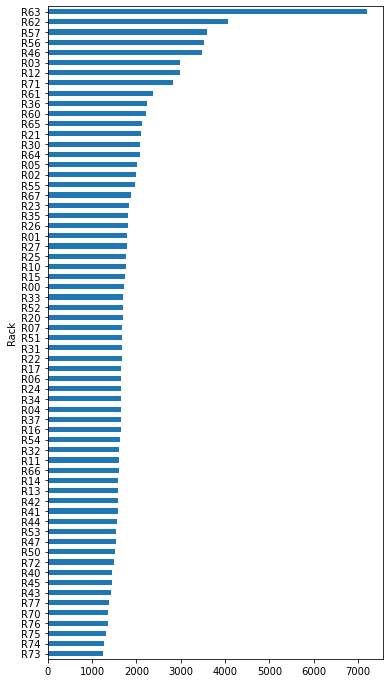

In [6]:
plt.figure(figsize=(6,12))
df_bgl.groupby(by='Rack').Timestamp.count().sort_values().plot.barh()
plt.show()

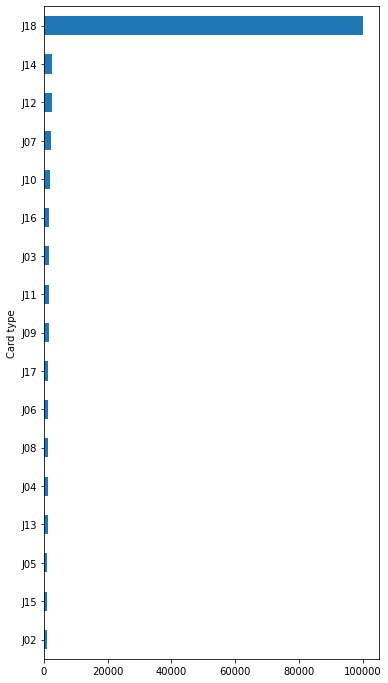

In [7]:
plt.figure(figsize=(6,12))
df_bgl.groupby(by='Card type').Timestamp.count().sort_values().plot.barh()
plt.show()

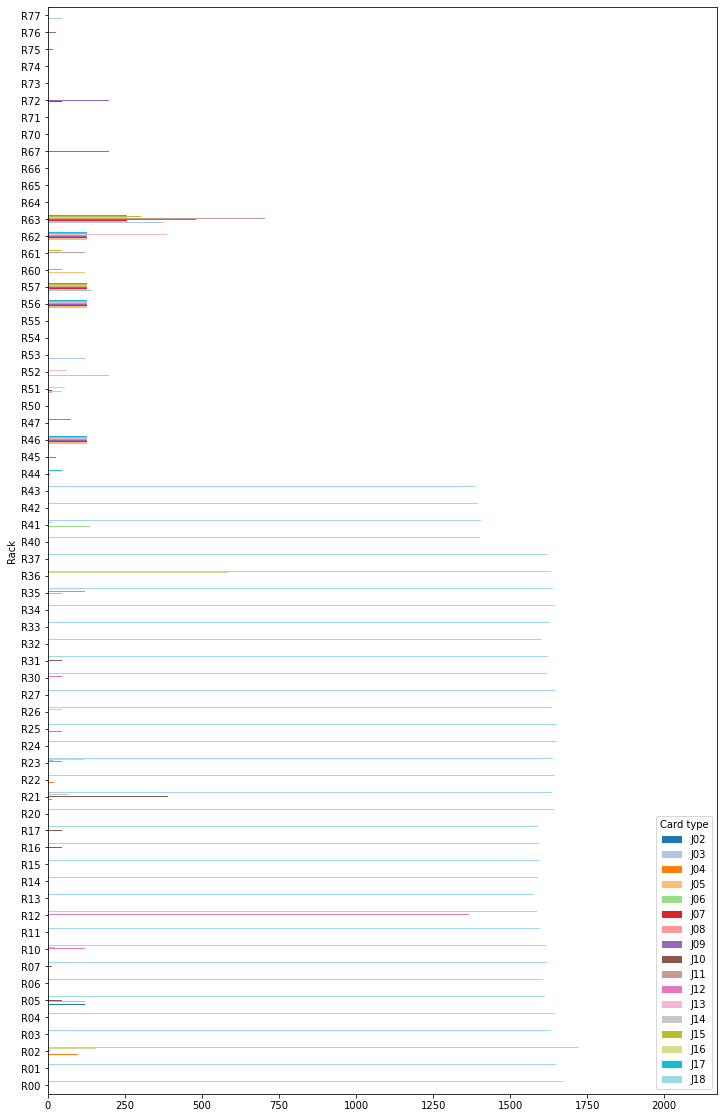

In [8]:
df_bgl.groupby(by=['Rack','Card type']).Timestamp.count().unstack(1).plot.barh(figsize=(12,20), cmap = 'tab20')
plt.show()

In [9]:
top_5 = df_bgl.groupby(by=['Rack']).Timestamp.count().sort_values(ascending=False)[0:5].index

df_top_5 = df_bgl.loc[df_bgl['Rack'] == top_5[0]]
for r in range(1,5):
    df_top_5 = df_top_5.append(df_bgl.loc[df_bgl['Rack'] == top_5[r]])
    
df_top_5

,Timestamp,ID-Node,Rack,Midplane,Node,Card,Card type,Message
356,1128641308,R63-M1-NC,R63,M1,NC,J18-U11,J18,ciod: Error reading message prefix after LOGI...
357,1128641308,R63-M1-NC,R63,M1,NC,J18-U01,J18,ciod: Error reading message prefix after LOGI...
400,1128641312,R63-M0-N0,R63,M0,N0,J18-U11,J18,ciod: Error reading message prefix after LOGI...
401,1128641312,R63-M0-N0,R63,M0,N0,J18-U01,J18,ciod: Error reading message prefix after LOGI...
414,1128641314,R63-M0-NC,R63,M0,NC,J18-U11,J18,ciod: Error reading message prefix after LOGI...
...,...,...,...,...,...,...,...,...
125354,1136322612,R46-M1-N0,R46,M1,N0,J18-U11,J18,Lustre mount FAILED : bglio613 : block_id : l...
125399,1136322626,R46-M0-NC,R46,M0,NC,J18-U11,J18,Lustre mount FAILED : bglio619 : block_id : l...
125473,1136322646,R46-M1-NC,R46,M1,NC,J18-U01,J18,Lustre mount FAILED : bglio624 : block_id : l...
125571,1136322666,R46-M1-N0,R46,M1,N0,J18-U01,J18,Lustre mount FAILED : bglio614 : block_id : l...


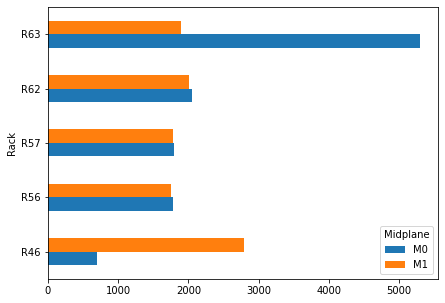

In [10]:
df_top_5.groupby(by=['Rack', 'Midplane']).Timestamp.count().unstack(1).plot.barh(figsize=(7,5))
plt.show()

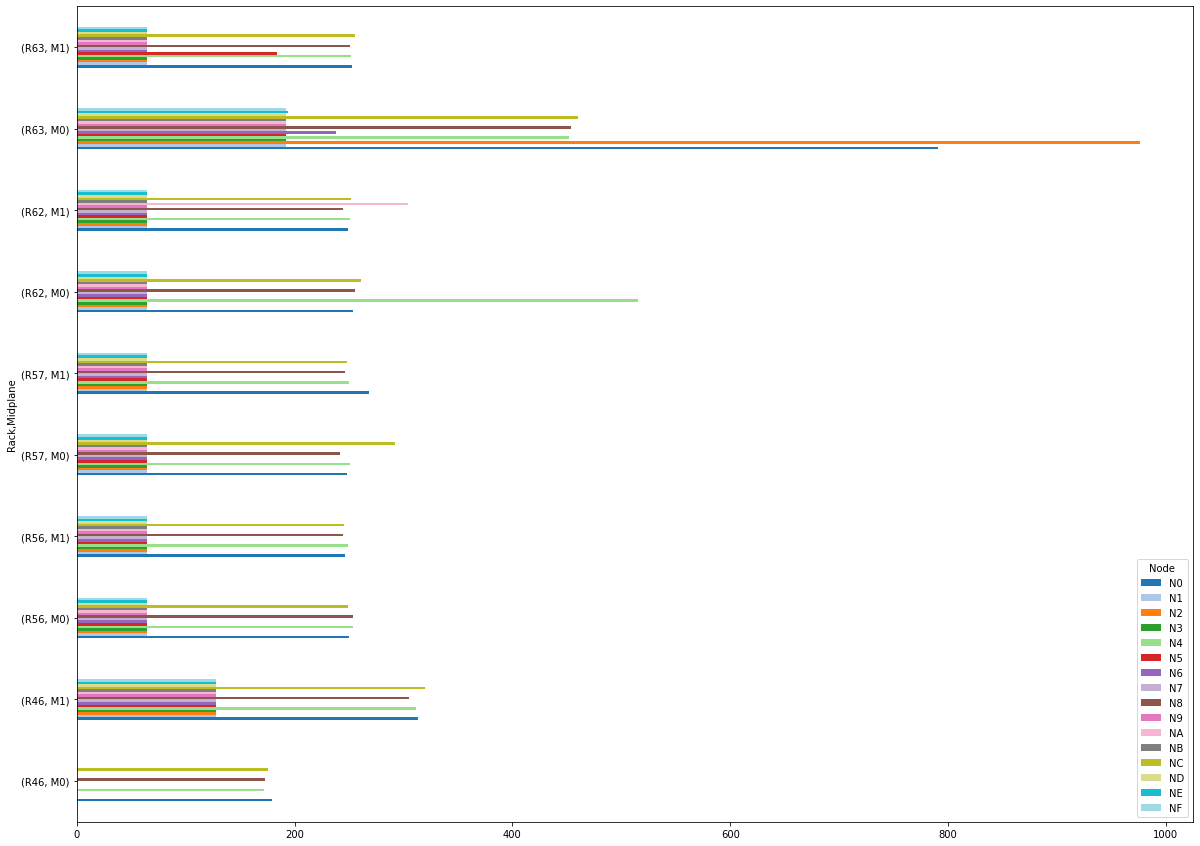

In [11]:
df_top_5.groupby(by=['Rack', 'Midplane', 'Node']).Timestamp.count().unstack(2).plot.barh(figsize=(20,15), cmap = 'tab20')
plt.show()

In [138]:
top_5_node = df_bgl.groupby(by=['ID-Node']).Timestamp.count().sort_values(ascending=False)[0:5].index

df_top_5_node = df_bgl.loc[df_bgl['ID-Node'] == top_5_node[0]]
for r in range(1,5):
    df_top_5_node = df_top_5_node.append(df_bgl.loc[df_bgl['ID-Node'] == top_5_node[r]])
    
df_top_5_node

,Timestamp,ID-Node,Rack,Midplane,Node,Card,Card type,Message,Tuple
1006,1128641385,R71-M0-N4,R71,M0,N4,J18-U11,J18,ciod: Error reading message prefix after LOGI...,1
1007,1128641385,R71-M0-N4,R71,M0,N4,J18-U01,J18,ciod: Error reading message prefix after LOGI...,1
2298,1128970796,R71-M0-N4,R71,M0,N4,J18-U11,J18,ciod: Error reading message prefix after LOAD...,17
2299,1128970796,R71-M0-N4,R71,M0,N4,J18-U01,J18,ciod: Error reading message prefix after LOAD...,17
3289,1129165930,R71-M0-N4,R71,M0,N4,J18-U11,J18,ciod: Error loading /home/spelce1/HPCC_IBM/Ur...,20
...,...,...,...,...,...,...,...,...,...
123396,1135630211,R63-M0-N0,R63,M0,N0,J18-U11,J18,ciod: Error reading message prefix on CioStre...,344
123397,1135630211,R63-M0-N0,R63,M0,N0,J18-U01,J18,ciod: Error reading message prefix on CioStre...,344
124615,1135957343,R63-M0-N0,R63,M0,N0,J18-U11,J18,ciod: Error reading message prefix on CioStre...,350
124616,1135957343,R63-M0-N0,R63,M0,N0,J18-U01,J18,ciod: Error reading message prefix on CioStre...,350


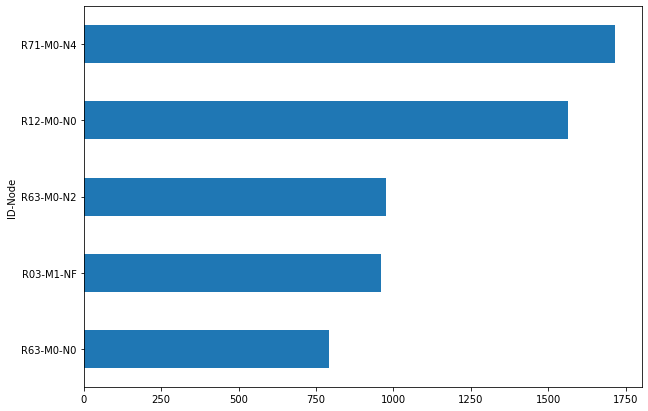

In [142]:
df_top_5_node.groupby(by='ID-Node').Timestamp.count().sort_values(ascending=True).plot.barh(figsize=(10,7), cmap = 'tab20')
plt.show()

# Data Manipulation

## System

### Temporal coalescence

#### Sensitivity analysis

File already exists!



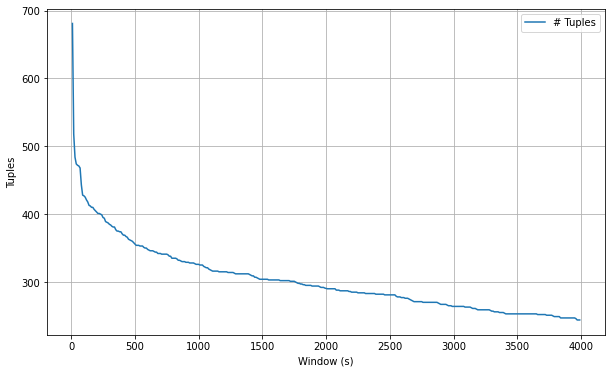

In [12]:
c_wins = np.delete(np.arange(0,4000,10), 0)

filepath = 'Dataset/BlueGeneL/System/BGL-Sensitivity.csv'

df_bgl_sensitivity = sensitivity_analysis(df_bgl, c_wins, filepath)

plt.figure(figsize=(10,6))
plt.plot(df_bgl_sensitivity['Window'],df_bgl_sensitivity['Tuples'], label = '# Tuples')

plt.xlabel('Window (s)')
plt.ylabel('Tuples')
plt.legend()
plt.grid()

#### Tupling

In [13]:
window = 500

filepath = 'Dataset/BlueGeneL/System/BGL-Data.csv'

df_bgl = tupling(df_bgl, window, filepath)
df_bgl = df_bgl.astype({'Timestamp' : 'int32', 'Tuple' : 'int32'})
df_bgl.head()

Creating file Dataset/BlueGeneL/System/BGL-Data.csv this may take a while...



,Timestamp,ID-Node,Rack,Midplane,Node,Card,Card type,Message,Tuple
0,1128621350,R00-M0-N0,R00,M0,N0,J18-U01,J18,Lustre mount FAILED : bglio2 : block_id : loc...,0
1,1128621350,R01-M1-N0,R01,M1,N0,J18-U11,J18,Lustre mount FAILED : bglio21 : block_id : lo...,0
2,1128621351,R07-M0-NC,R07,M0,NC,J18-U01,J18,Lustre mount FAILED : bglio124 : block_id : l...,0
3,1128621351,R00-M0-N4,R00,M0,N4,J18-U01,J18,Lustre mount FAILED : bglio4 : block_id : loc...,0
4,1128621351,R02-M0-N4,R02,M0,N4,J18-U01,J18,Lustre mount FAILED : bglio36 : block_id : lo...,0


In [14]:
num_tuple = df_bgl.max(axis = 0).loc['Tuple'] + 1
print('Number of tuples: ', num_tuple)

Number of tuples:  356


In [15]:
df_sys_stat = statistics(df_bgl)
df_sys_stat.head()

,# Entries,Start time,End time,Length,Density,Interarrival
Tuple,,,,,,
0,128,1128621350,1128621367,17,7.529412,NaN
1,1024,1128641281,1128641411,130,7.876923,19914.0
2,23,1128702415,1128702464,49,0.469388,61004.0
3,9,1128719240,1128719316,76,0.118421,16776.0
4,14,1128747957,1128748024,67,0.208955,28641.0


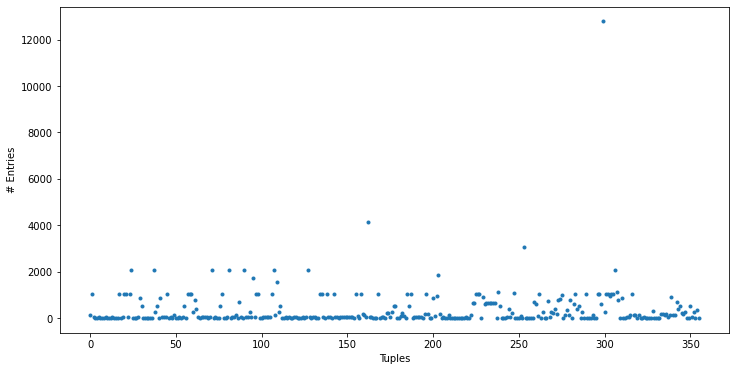

In [16]:
x = df_sys_stat.index
y = df_sys_stat['# Entries']

plt.figure(figsize=(12,6))
plt.scatter(x, y, marker = '.')
plt.xlabel('Tuples')
plt.ylabel('# Entries')
plt.show()

In [34]:
df_group = df_bgl.groupby(by=['Tuple','Card type']).count()

x = df_group.index.get_level_values(0)

# y = df_sys_stat['# Entries']

# plt.figure(figsize=(12,6))
# plt.scatter(x, y, marker = '.')
# plt.xlabel('Tuples')
# plt.ylabel('# Entries')
# plt.show()

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            347, 348, 349, 350, 351, 352, 352, 353, 354, 355],
           dtype='int64', name='Tuple', length=537)

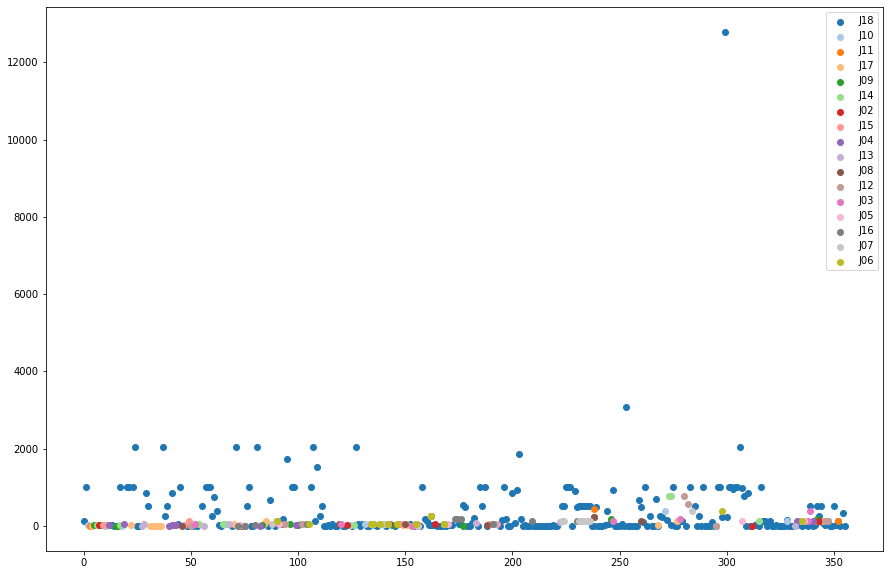

In [86]:
cmap = cm.get_cmap('tab20')
colors = cmap.colors

fig, ax = plt.subplots(figsize=(15,10))
ax.set_prop_cycle(color=colors)

for card in df_bgl['Card type'].unique():
    df_temp = df_group[df_group.index.get_level_values('Card type').isin([card])]
    
    x = df_temp.index.get_level_values(0)
    y = df_temp['Timestamp']
    
    plt.scatter(x,y, label=card, marker = 'o')

    
plt.legend()
plt.show()

#### Bottleneck

### Spatial coalescence

### Content-based coalescence

### Truncation analysis

In [113]:
q = df_sys_stat['Interarrival'].quantile(q=0.1)
print("0.1 quantile: " + str(q))

0.1 quantile: 1073.6


In [114]:
df_trunc = df_sys_stat.loc[df_sys_stat['Interarrival'] <= q]
df_trunc.head()

,# Entries,Start time,End time,Length,Density,Interarrival
Tuple,,,,,,
7,20,1128801670,1128801722,52,0.384615,828.0
14,1,1128944032,1128944032,0,inf,969.0
21,1024,1129166602,1129166717,115,8.904348,647.0
35,2,1129300645,1129300645,0,inf,851.0
36,2,1129301206,1129301206,0,inf,561.0


In [115]:
num_trunc = df_trunc.shape[0]
perc_trunc = (num_trunc/num_tuple)*100

print('Estimate number of truncations:', num_trunc)
print('Estimate percentage of truncations:', perc_trunc)

Estimate number of truncations: 36
Estimate percentage of truncations: 10.112359550561797


### Collision analysis

In [118]:
df_group = df_bgl.groupby(by=['Tuple','Rack']).count()
df_group = df_group.reset_index(level = 1)

collided = 0
for tup in df_group.index.unique():
    if df_group.loc[df_group.index == tup].shape[0] > 1:
        collided = collided + 1

In [119]:
perc_coll = (collided/num_tuple)*100

print('Estimate number of collisions:', collided)
print('Estimate percentage of collisions: ', perc_coll)

Estimate number of collisions: 177
Estimate percentage of collisions:  49.71910112359551


In [120]:
df_group = df_bgl.groupby(by=['Tuple','Card type']).count()
df_group = df_group.reset_index(level = 1)

collided = 0
for tup in df_group.index.unique():
    if df_group.loc[df_group.index == tup].shape[0] > 1:
        collided = collided + 1

In [121]:
perc_coll = (collided/num_tuple)*100

print('Estimate number of collisions:', collided)
print('Estimate percentage of collisions: ', perc_coll)

Estimate number of collisions: 55
Estimate percentage of collisions:  15.44943820224719


In [129]:
pd.set_option('display.max_rows', 50)

df_bgl.groupby(by=['Tuple','Rack','Midplane','Node','Card']).count()

Timestamp  ID-Node  Card type  Message
Tuple Rack Midplane Node Card                                           
0     R00  M0       N0   J18-U01          1        1          1        1
                         J18-U11          1        1          1        1
                    N4   J18-U01          1        1          1        1
                         J18-U11          1        1          1        1
                    N8   J18-U01          1        1          1        1
...                                     ...      ...        ...      ...
355   R31  M0       NC   J18-U11          1        1          1        1
           M1       NC   J18-U11          1        1          1        1
      R34  M0       NC   J18-U11          1        1          1        1
      R36  M0       NC   J18-U11          1        1          1        1
      R50  M1       NC   J18-U11          1        1          1        1

[79598 rows x 4 columns]

## Subsystems

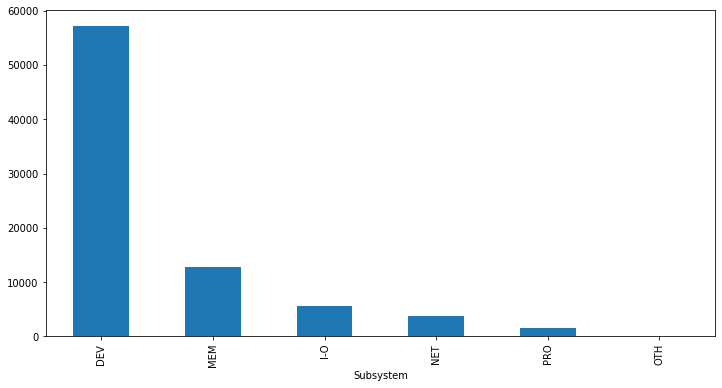

In [30]:
plt.figure(figsize=(12,6))
df_mercury.groupby(by=['Subsystem']).Timestamp.count().sort_values(ascending = False).plot.bar()
plt.show()

In [31]:
subsystems = df_mercury.groupby(by=['Subsystem']).Timestamp.count().sort_values(ascending = False).drop('OTH')

### Temporal coalescence

#### Sensitivity analysis

In [32]:
c_wins = np.delete(np.arange(0,500,1), 0)

for subsys in subsystems.index:
    df_temp = df_mercury.loc[df_mercury['Subsystem'] == subsys]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = 'Dataset/Mercury/Subsystems/Mercury-' + subsys + '-Sensitivity.csv'
    
    sensitivity_analysis(df_temp, c_wins, filepath)

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!



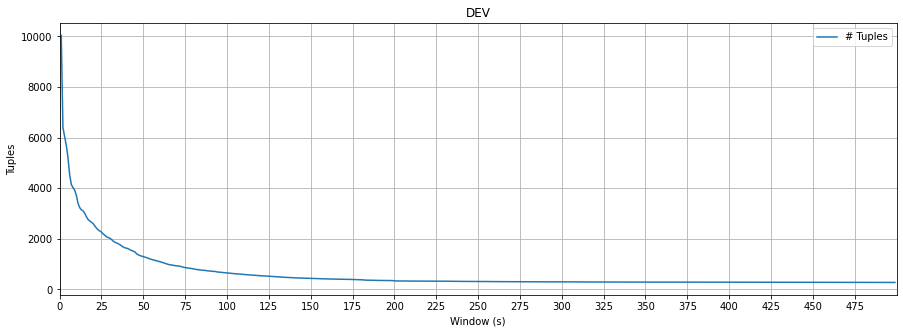

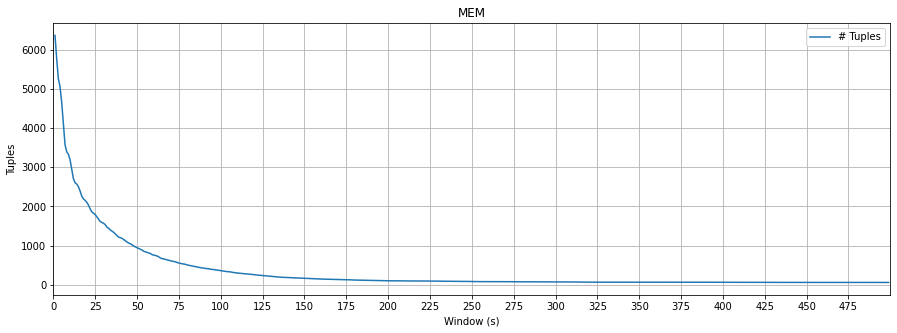

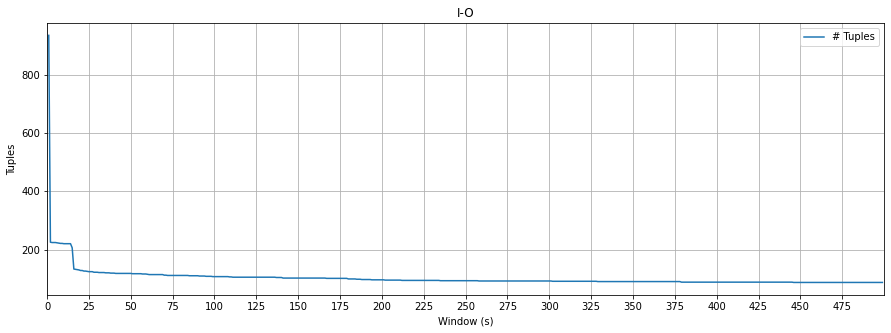

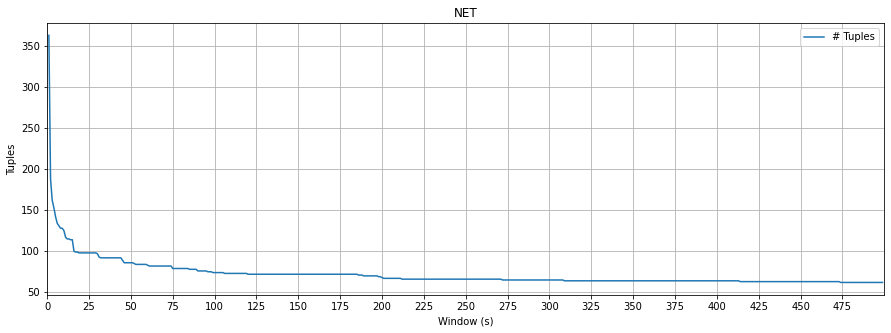

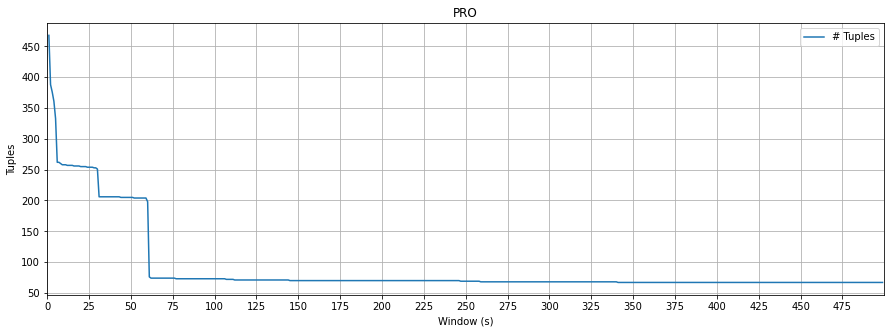

In [33]:
for subsys in subsystems.index:
    filepath = 'Dataset/Mercury/Subsystems/Mercury-' + subsys + '-Sensitivity.csv'
    
    df_temp_sensitivity = pd.read_csv(filepath, index_col = 0)
    
    x = df_temp_sensitivity['Window']
    y = df_temp_sensitivity['Tuples']
    
    plt.figure(figsize=(15,5))
    plt.plot(x, y, label = '# Tuples')
    plt.title(subsys)
    plt.xlim(0,500)
    plt.xticks(np.arange(0, 500, step = 25))
    plt.xlabel('Window (s)')
    plt.ylabel('Tuples')
    plt.legend()
    plt.grid()

In [34]:
win_dict = {'DEV' : 200,
            'MEM' : 200,
            'I-O' : 100,
            'NET' : 100,
            'PRO' : 100}
print('Selected coalescence windows:', win_dict)

Selected coalescence windows: {'DEV': 200, 'MEM': 200, 'I-O': 100, 'NET': 100, 'PRO': 100}


#### Tupling

In [35]:
dict_df_cat_stat = {}
dict_cat_num_tup = {}

for subsys in subsystems.index:
    df_temp = df_mercury.loc[df_mercury['Subsystem'] == subsys]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = 'Dataset/Mercury/Subsystems/Mercury-' + subsys + '-Data.csv'
    
    df_tupling = tupling(df_temp, win_dict[subsys], filepath)
    num_tup = df_tupling.max(axis = 0).loc['Tuple'] + 1
    dict_cat_num_tup[subsys] = num_tup
    
    df_stat = statistics(df_tupling)
    dict_df_cat_stat[subsys] = df_stat

print('Number of tuples:', dict_cat_num_tup)

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!

Number of tuples: {'DEV': 334, 'MEM': 105, 'I-O': 107, 'NET': 74, 'PRO': 73}


## Types

In [36]:
df_mercury.loc[df_mercury['Node'].str.contains('login'), 'Type'] = 'login'
df_mercury.loc[df_mercury['Node'].str.contains('c'), 'Type'] = 'computation'
df_mercury.loc[df_mercury['Node'].str.contains('s'), 'Type'] = 'storage'
df_mercury.loc[df_mercury['Node'].str.contains('master'), 'Type'] = 'master'

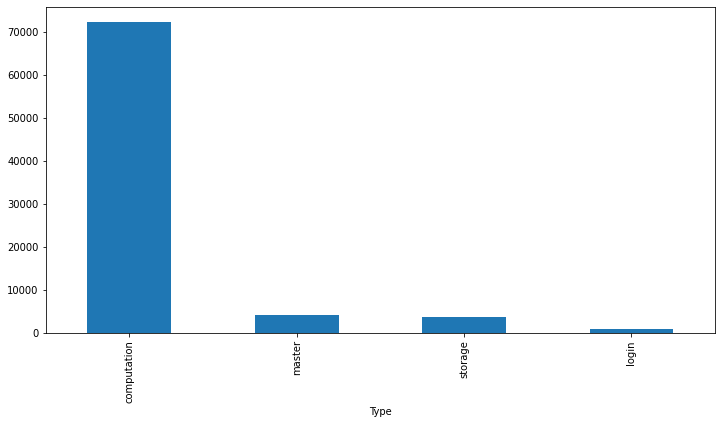

In [37]:
plt.figure(figsize=(12,6))
df_mercury.groupby(by=['Type']).Timestamp.count().sort_values(ascending = False).plot.bar()
plt.show()

In [38]:
types = df_mercury.groupby(by=['Type']).Timestamp.count().sort_values(ascending = False)

### Temporal coalescence

#### Sensitivity analysis

In [39]:
c_wins = np.delete(np.arange(0,500,1), 0)

for t in types.index:
    df_temp = df_mercury.loc[df_mercury['Type'] == t]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = 'Dataset/Mercury/Types/Mercury-' + t + '-Sensitivity.csv'
    
    sensitivity_analysis(df_temp, c_wins, filepath)

File already exists!

File already exists!

File already exists!

File already exists!



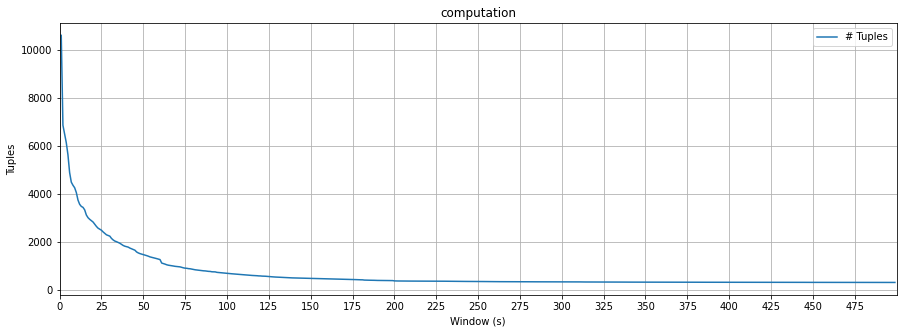

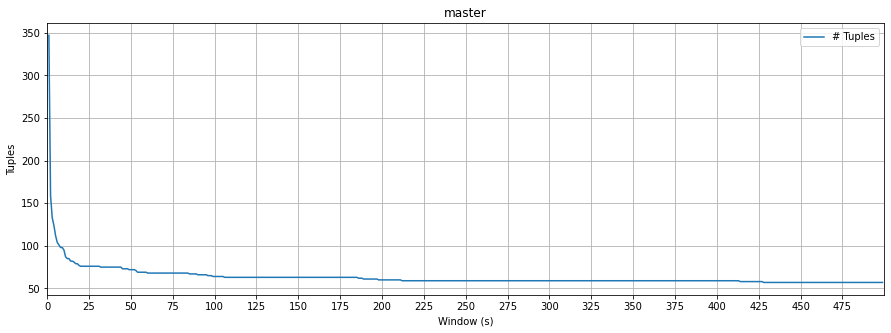

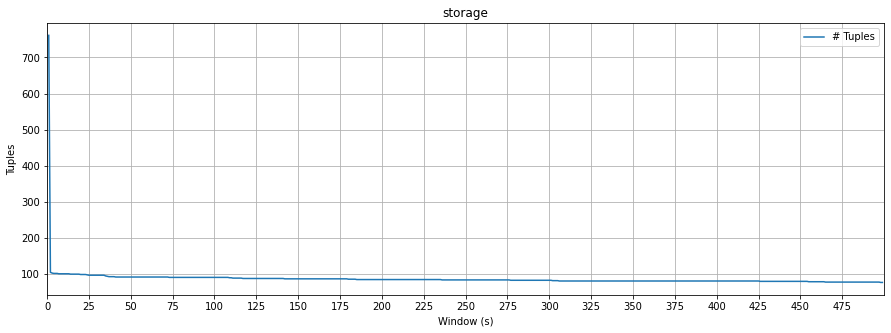

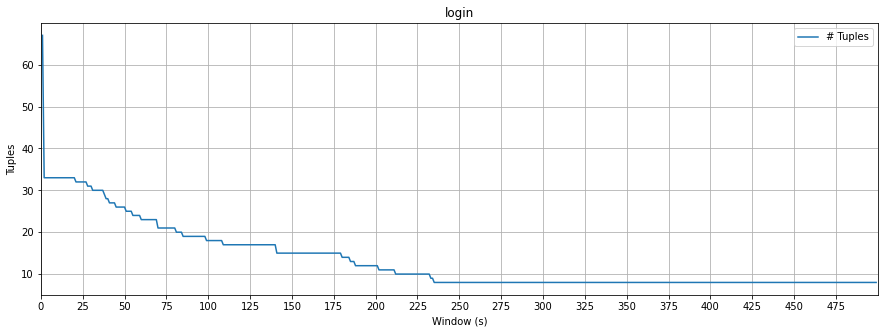

In [40]:
for t in types.index:
    filepath = 'Dataset/Mercury/Types/Mercury-' + t + '-Sensitivity.csv'
    
    df_temp_sensitivity = pd.read_csv(filepath, index_col = 0)
    
    x = df_temp_sensitivity['Window']
    y = df_temp_sensitivity['Tuples']
    
    plt.figure(figsize=(15,5))
    plt.plot(x, y, label = '# Tuples')
    plt.title(t)
    plt.xlim(0,500)
    plt.xticks(np.arange(0, 500, step = 25))
    plt.xlabel('Window (s)')
    plt.ylabel('Tuples')
    plt.legend()
    plt.grid()

In [41]:
win_dict = {'computation' : 200,
            'master' : 150,
            'storage' : 100,
            'login' : 300}
print('Selected coalescence windows:', win_dict)

Selected coalescence windows: {'computation': 200, 'master': 150, 'storage': 100, 'login': 300}


#### Tupling

In [42]:
dict_df_type_stat = {}
dict_type_num_tup = {}

for t in types.index:
    df_temp = df_mercury.loc[df_mercury['Type'] == t]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = 'Dataset/Mercury/Types/Mercury-' + t + '-Data.csv'
    
    df_tupling = tupling(df_temp, win_dict[t], filepath)
    num_tup = df_tupling.max(axis = 0).loc['Tuple'] + 1
    dict_type_num_tup[t] = num_tup
    
    df_stat = statistics(df_tupling)
    dict_df_type_stat[t] = df_stat

print('Number of tuples:', dict_type_num_tup)

File already exists!

File already exists!

File already exists!

File already exists!

Number of tuples: {'computation': 382, 'master': 63, 'storage': 91, 'login': 8}


## Top nodes

In [43]:
print('Number of nodes that generates error: ' + str(len(df_mercury['Node'].unique())))

Number of nodes that generates error: 53


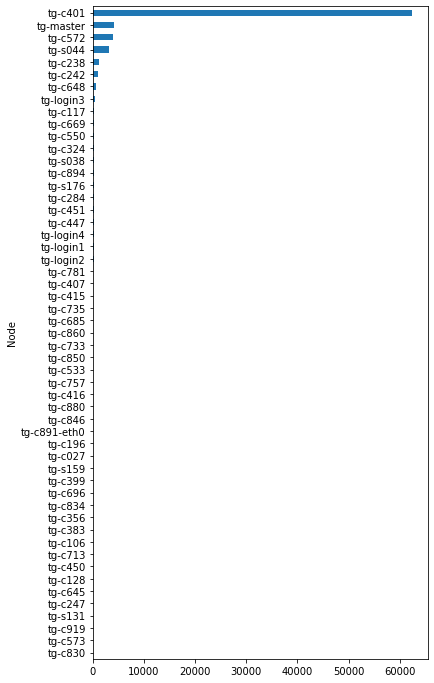

In [44]:
plt.figure(figsize=(6,12))
df_mercury.groupby(by='Node').Timestamp.count().sort_values().plot.barh()
plt.show()

In [45]:
top_5 = df_mercury.groupby(by='Node').Timestamp.count().sort_values(ascending = False)[0:5]
top_5

Node
tg-c401      62340
tg-master     4098
tg-c572       4030
tg-s044       3224
tg-c238       1273
Name: Timestamp, dtype: int64

### Temporal coalescence

#### Sensitivity analysis

In [46]:
c_wins = np.delete(np.arange(0,500,1), 0)

for node in top_5.index:
    df_temp = df_mercury.loc[df_mercury['Node'] == node]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = 'Dataset/Mercury/TopNodes/Mercury-' + node + '-Sensitivity.csv'
    sensitivity_analysis(df_temp, c_wins, filepath)

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!



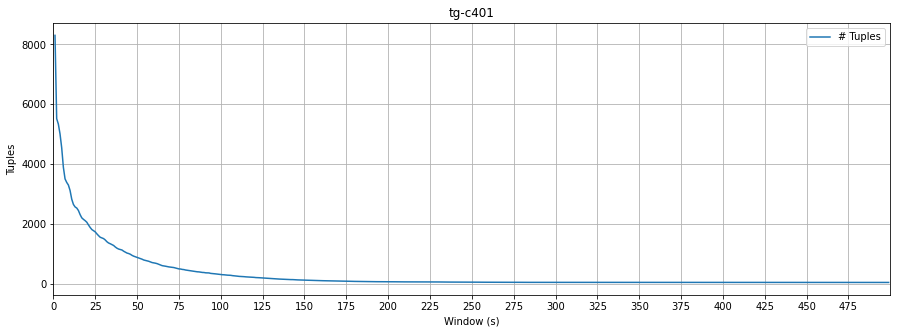

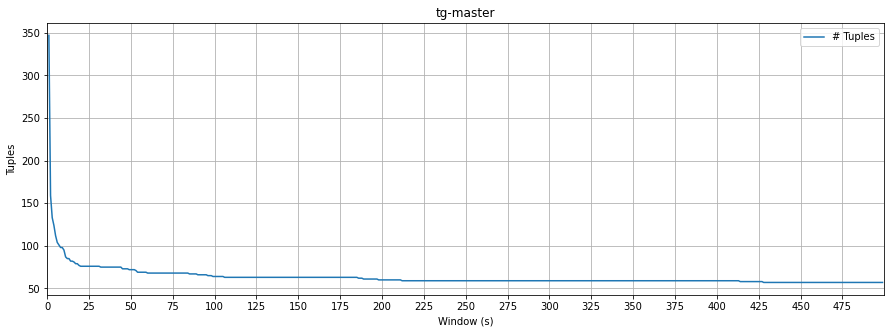

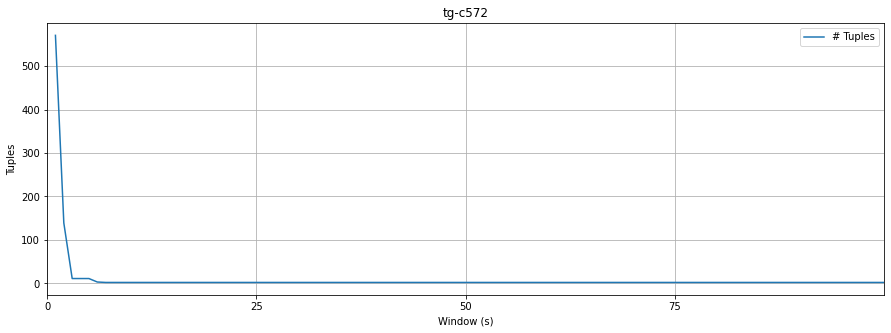

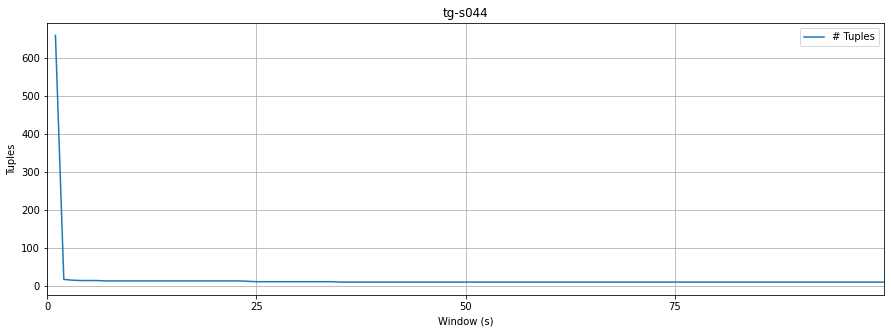

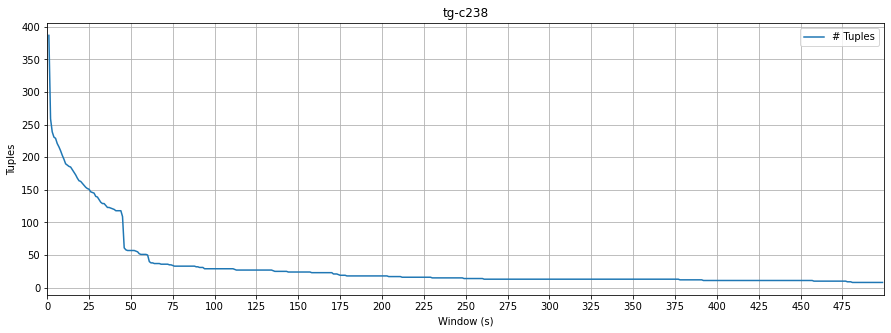

In [47]:
x_dict = {'tg-c401' : 500,
          'tg-master' : 500,
          'tg-c572' : 100,
          'tg-s044' : 100,
          'tg-c238' : 500}

for node in top_5.index:
    filepath = 'Dataset/Mercury/TopNodes/Mercury-' + node + '-Sensitivity.csv'
    
    df_temp_sensitivity = pd.read_csv(filepath, index_col = 0)
    
    x = df_temp_sensitivity['Window']
    y = df_temp_sensitivity['Tuples']
    
    plt.figure(figsize=(15,5))
    plt.plot(x, y, label = '# Tuples')
    plt.title(node)
    plt.xlim(0,x_dict[node])
    plt.xticks(np.arange(0, x_dict[node], step = 25))
    plt.xlabel('Window (s)')
    plt.ylabel('Tuples')
    plt.legend()
    plt.grid()

In [48]:
win_dict = {'tg-c401' : 200,
            'tg-master' : 200,
            'tg-c572' : 20,
            'tg-s044' : 30,
            'tg-c238' : 200}

print('Selected coalescence windows:', win_dict)

Selected coalescence windows: {'tg-c401': 200, 'tg-master': 200, 'tg-c572': 20, 'tg-s044': 30, 'tg-c238': 200}


#### Tupling

In [49]:
dict_df_node_stat = {}
dict_node_num_tup = {}

for node in top_5.index:
    df_temp = df_mercury.loc[df_mercury['Node'] == node]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = 'Dataset/Mercury/TopNodes/Mercury-' + node + '-Data.csv'
    
    df_tupling = tupling(df_temp, win_dict[node], filepath)
    num_tup = df_tupling.max(axis = 0).loc['Tuple'] + 1
    dict_node_num_tup[node] = num_tup
    
    df_stat = statistics(df_tupling)
    dict_df_node_stat[node] = df_stat
    
print('Number of tuples:', dict_node_num_tup)

File already exists!

File already exists!

File already exists!

File already exists!

File already exists!

Number of tuples: {'tg-c401': 59, 'tg-master': 60, 'tg-c572': 2, 'tg-s044': 11, 'tg-c238': 18}


## Bottleneck

### Temporal coalescence

#### Sensitivity analysis

File already exists!



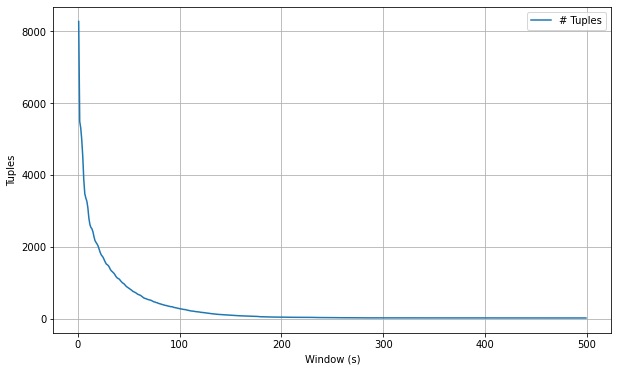

In [50]:
c_wins = np.delete(np.arange(0,500,1), 0)

filepath = 'Dataset/Mercury/Bottleneck/Mercury-bottleneck-Sensitivity.csv'

df_bottleneck.reset_index(drop = True, inplace = True)
df_bottleneck_sensitivity = sensitivity_analysis(df_bottleneck, c_wins, filepath)

plt.figure(figsize=(10,6))

plt.plot(df_bottleneck_sensitivity['Window'], df_bottleneck_sensitivity['Tuples'], label = '# Tuples')

plt.xlabel('Window (s)')
plt.ylabel('Tuples')
plt.legend()
plt.grid()

#### Tupling

In [51]:
window = 200
filepath = 'Dataset/Mercury/Bottleneck/Mercury-bottleneck-Data.csv'

df_bottleneck = tupling(df_bottleneck, window, filepath)
df_bottleneck = df_bottleneck.astype({'Timestamp' : 'int32', 'Tuple' : 'int32'})
df_bottleneck.head()

File already exists!



,Timestamp,Node,Subsystem,Message,Tuple,Type
0,1171321113,tg-c401,DEV,+BEGIN HARDWARE ERROR STATE AT CPE,0,computation
1,1171321113,tg-c401,DEV,+Platform PCI Component Error Info Section,0,computation
2,1171321113,tg-c401,DEV,Component Info: Vendor Id =x x,0,computation
3,1171321156,tg-c401,DEV,+BEGIN HARDWARE ERROR STATE AT CPE,0,computation
4,1171321156,tg-c401,DEV,+Platform PCI Component Error Info Section,0,computation


In [52]:
num_tuple = df_bottleneck.max(axis = 0).loc['Tuple'] + 1
print('Number of tuples: ', num_tuple)

Number of tuples:  37


In [53]:
df_bottleneck_stat = statistics(df_bottleneck)
df_bottleneck_stat.head()

,# Entries,Start time,End time,Length,Density,Interarrival
Tuple,,,,,,
0,8569,1171321113,1171337216,16103,0.532137,NaN
1,9822,1171337536,1171356961,19425,0.505637,320.0
2,503,1171357195,1171358506,1311,0.383677,234.0
3,11,1171358737,1171358737,0,inf,231.0
4,1133,1171359013,1171360978,1965,0.576590,276.0


# Data analysis

## System

### Empirical time to failure distribution

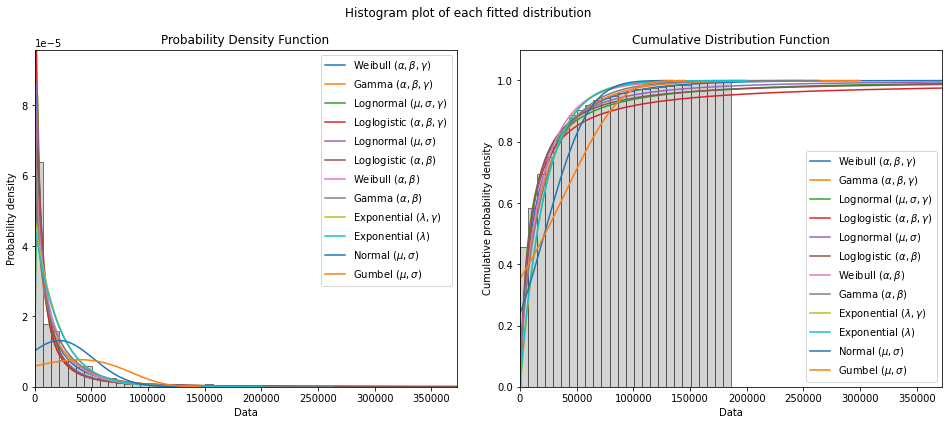

The best fitting distribution was Weibull_3P which had parameters [1.62018413e+04 6.71661886e-01 5.02999900e+02]


In [124]:
data = df_sys_stat['Interarrival'].dropna().to_numpy()

results = Fit_Everything(failures=data, show_PP_plot = False, show_probability_plot = False, print_results = False, show_histogram_plot = True) 
print('The best fitting distribution was', results.best_distribution_name, 'which had parameters', results.best_distribution.parameters)

In [125]:
results.results

,Alpha,Beta,Gamma,Mu,Sigma,Lambda,AICc,BIC,AD
Distribution,,,,,,,,,
Weibull_3P,16201.8,0.671662,503,,,,7678.767803,7690.315780,0.409612
Gamma_3P,38593.3,0.550638,503,,,,7682.249980,7693.797958,0.999290
Lognormal_3P,,,421.488,8.92732,1.67661,,7718.829379,7730.377357,2.231110
Loglogistic_3P,8016.17,0.957326,503,,,,7725.206722,7736.754700,2.160633
Lognormal_2P,,,,9.09143,1.45089,,7730.638737,7738.348882,1.911553
Loglogistic_2P,8878.85,1.15471,,,,,7755.494045,7763.204189,2.493192
Weibull_2P,17606.9,0.838365,,,,,7759.648028,7767.358173,4.268847
Gamma_2P,32109,0.677502,,,,,7763.538281,7771.248425,4.012849
Exponential_2P,,,502.999,,,4.70568e-05,7788.584167,7796.294312,27.958509


Results from Fit_Weibull_3P (95% CI):
           Point Estimate  Standard Error      Lower CI      Upper CI
Parameter                                                            
Alpha        16201.841255     1347.762937  13764.375163  19070.946333
Beta             0.671662        0.027957      0.619042      0.728754
Gamma          502.999900        0.000174    502.999558    503.000242
Log-Likelihood: -3836.349713243326 



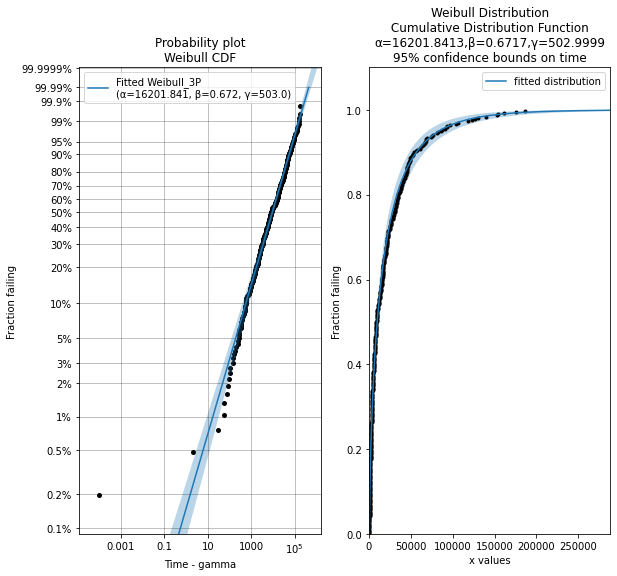

In [126]:
alpha = results.results.loc['Weibull_3P','Alpha']
beta = results.results.loc['Weibull_3P','Beta']
gamma = results.results.loc['Weibull_3P','Gamma']

plt.subplot(121)
fit = Fit_Weibull_3P(failures=data)
plt.subplot(122)
fit.distribution.CDF(label='fitted distribution')
plot_points(failures=data, func='CDF')

plt.legend()
plt.show()

Kolmogorov-Smirnov statistic: 0.027993496341964796
Kolmogorov-Smirnov critical value: 0.07149365187130802
At the 0.05 significance level, we can ACCEPT the hypothesis that the data comes from a Weibull Distribution (α=16201.8413,β=0.6717,γ=502.9999)


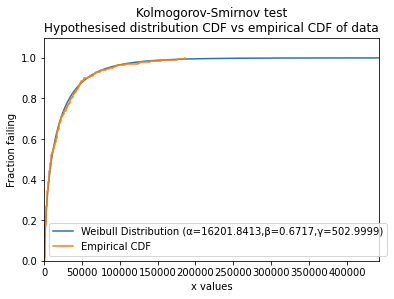

In [127]:
dist = Weibull_Distribution(alpha=alpha, beta=beta, gamma=gamma)

result = KStest(distribution = dist, data = df_sys_stat['Interarrival'].to_numpy(), significance = 0.05)

### Empirical reliability

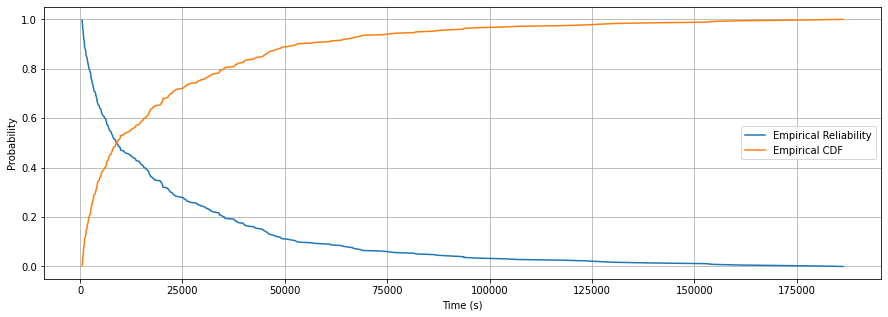

In [128]:
ecdf = ECDF(data)

plt.figure(figsize=(15,5))
    
plt.plot(ecdf.x, 1-ecdf.y, label = 'Empirical Reliability')
plt.plot(ecdf.x, ecdf.y, label = 'Empirical CDF')

plt.xlabel('Time (s)')
plt.ylabel('Probability')
plt.legend()
plt.grid()

### General Analysis

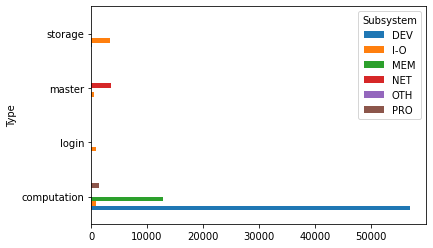

In [59]:
df_mercury.groupby(by=['Subsystem','Type']).Timestamp.count().unstack(0).plot.barh()
plt.show()

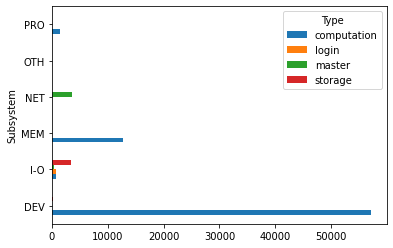

In [60]:
df_mercury.groupby(by=['Subsystem','Type']).Timestamp.count().unstack(1).plot.barh()
plt.show()

In [61]:
print('Distinct error messages:', df_mercury.groupby(by='Message').count().shape[0])

Distinct error messages: 48


In [62]:
df_mercury.groupby(by='Message').count().sort_values(by='Timestamp', ascending=False).head(10).drop(columns=df_mercury.groupby(by='Message').count().columns[1:5])

,Timestamp
Message,
Component Info: Vendor Id =x x,25712
Physical Address x,12746
+Platform PCI Component Error Info Section,8221
+BEGIN HARDWARE ERROR STATE AT CPE,7498
+ Platform Specific Error Detail:,5929
+Platform Specific Error Info Section,5812
+END HARDWARE ERROR STATE AT CPE,4021
setting node state to down,3635
error: dev x:x,2944


In [63]:
df_mercury.groupby(by=['Subsystem','Message']).count().drop(columns=['Node', 'Type', 'Tuple'])

Timestamp
Subsystem Message                                                      
DEV       + Platform Specific Error Detail:                        5929
          +BEGIN HARDWARE ERROR STATE AT CPE                       7498
          +END HARDWARE ERROR STATE AT CPE                         4021
          +Platform PCI Component Error Info Section               8221
          +Platform Specific Error Info Section                    5812
          Component Info: Vendor Id =x x                          25712
          EXx-fs abort (device sd(x                                   1
          EXx-fs error (device sd(x                                  11
          GM: LANAI[x]: LANai detected PARITY error at x[...          2
          GM: LANAI[x]: LANai detected PARITY error trans...          1
          GM: LANAI[x]: SRAM PARITY error                             4
          GM: NIC firmware error: GM aborted                          3
          GM: NOTICE: drivers gm lanai command.c:x:gm lan...          2
          GM: gm exit() called in the OTH: GM aborted<x>G...          6
          PCI: slot x:x.x has incorrect PCI cache line si...          3
          The NIC ISR is reporting an SRAM parity error               1
          firmware error-x:SRAM parity error on NIC                   5
          gm.interrupt.last byte.ready =x x                           3
          gm.interrupt.type =x x                                      5
          is->interrupt.last byte.ready =x x                          5
          is->interrupt.type =x x                                     3
I-O       OTH panic: REISERFS: panic (device x:x): journal-x          1
          SCSI Error: (x:x:x) Status=x (CHECK CONDITION)            112
          U=x                                                         1
          error                                                     577
          error: dev x:x                                           2944
          hda: packet command error: error=x                         43
          journal-x                                                   1
          qlx nvram config link down timeout=x                       12
          reservation scsi error created by x                         9
          reservation scsi error destroyed by x                       6
          scsx: ERROR on channel x                                   91
          unknown partition table                                     2
          x unknown partition table                                1748
MEM       + Mem Error Detail:                                        73
          Physical Address x                                      12746
NET       Additional sense indicates Mechanical positioni...         33
          The NIC ISR is reporting an SRAM parity error               1
          bonx: link status definitely down for interface...          2
          connection down                                            31
          setting node state to down                               3635
OTH       ?         mpd.run()                                         1
          GM: LANAI[x]: Program aborted.                              2
          GM: LANAI[x]: WARNING: libgm gm abort.c:x:gm ab...          5
          GM: gm exit() called in the OTH: GM aborted<x>G...          5
          OTH panic: REISERFS: panic (device x:x): journal-x          2
          PCI: slot x:x.x has incorrect PCI cache line si...          3
          alloc pages: x-order allocation failed (gfp=x              16
PRO       +BEGIN HARDWARE ERROR STATE AT CMC                        425
          +END HARDWARE ERROR STATE AT CMC                          252
          Device Error Info Section                                 413
          Error Map: x                                              414

In [64]:
pd.set_option('display.max_rows', None)
df_mercury.groupby(by=['Type','Message']).count().drop(columns=['Node', 'Subsystem', 'Tuple'])

Timestamp
Type        Message                                                      
computation + Mem Error Detail:                                        72
            + Platform Specific Error Detail:                        5928
            +BEGIN HARDWARE ERROR STATE AT CMC                        425
            +BEGIN HARDWARE ERROR STATE AT CPE                       7419
            +END HARDWARE ERROR STATE AT CMC                          252
            +END HARDWARE ERROR STATE AT CPE                         4010
            +Platform PCI Component Error Info Section               8164
            +Platform Specific Error Info Section                    5810
            ?         mpd.run()                                         1
            Additional sense indicates Mechanical positioni...         33
            Component Info: Vendor Id =x x                          25654
            Device Error Info Section                                 413
            EXx-fs abort (device sd(x                                   1
            EXx-fs error (device sd(x                                  11
            Error Map: x                                              414
            GM: LANAI[x]: LANai detected PARITY error at x[...          2
            GM: LANAI[x]: LANai detected PARITY error trans...          1
            GM: LANAI[x]: Program aborted.                              2
            GM: LANAI[x]: SRAM PARITY error                             4
            GM: LANAI[x]: WARNING: libgm gm abort.c:x:gm ab...          5
            GM: NIC firmware error: GM aborted                          3
            GM: NOTICE: drivers gm lanai command.c:x:gm lan...          2
            GM: gm exit() called in the OTH: GM aborted<x>G...         11
            OTH panic: REISERFS: panic (device x:x): journal-x          3
            Physical Address x                                      12746
            SCSI Error: (x:x:x) Status=x (CHECK CONDITION)            101
            The NIC ISR is reporting an SRAM parity error               2
            alloc pages: x-order allocation failed (gfp=x               2
            connection down                                            22
            error                                                     577
            error: dev x:x                                              7
            firmware error-x:SRAM parity error on NIC                   5
            gm.interrupt.last byte.ready =x x                           3
            gm.interrupt.type =x x                                      5
            hda: packet command error: error=x                         24
            is->interrupt.last byte.ready =x x                          5
            is->interrupt.type =x x                                     3
            journal-x                                                   1
            scsx: ERROR on channel x                                   91
login       SCSI Error: (x:x:x) Status=x (CHECK CONDITION)              2
            U=x                                                         1
            connection down                                             3
            hda: packet command error: error=x                         11
            qlx nvram config link down timeout=x                        9
            x unknown partition table                                 797
master      + Mem Error Detail:                                         1
            PCI: slot x:x.x has incorrect PCI cache line si...          6
            SCSI Error: (x:x:x) Status=x (CHECK CONDITION)              9
            connection down                                             4
            hda: packet command error: error=x                          3
            qlx nvram config link down timeout=x                        3
            reservation scsi error created by x                         9
            reservation scsi error destroyed by x                   

In [65]:
pd.reset_option('display.max_rows')

## Subsystems

### Empirical time to failure distribution

Subsystem: DEV


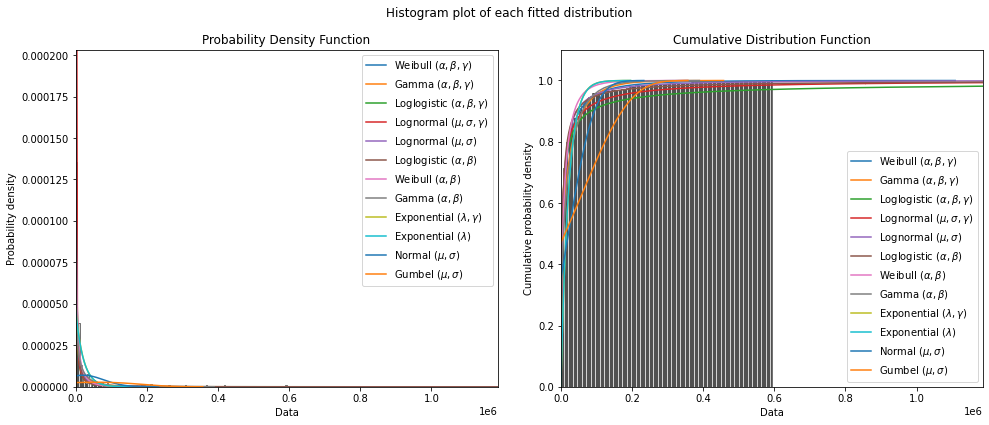

The best fitting distribution was Weibull_3P which had parameters [8.40701430e+03 4.54859607e-01 1.99999900e+02]
Subsystem: MEM


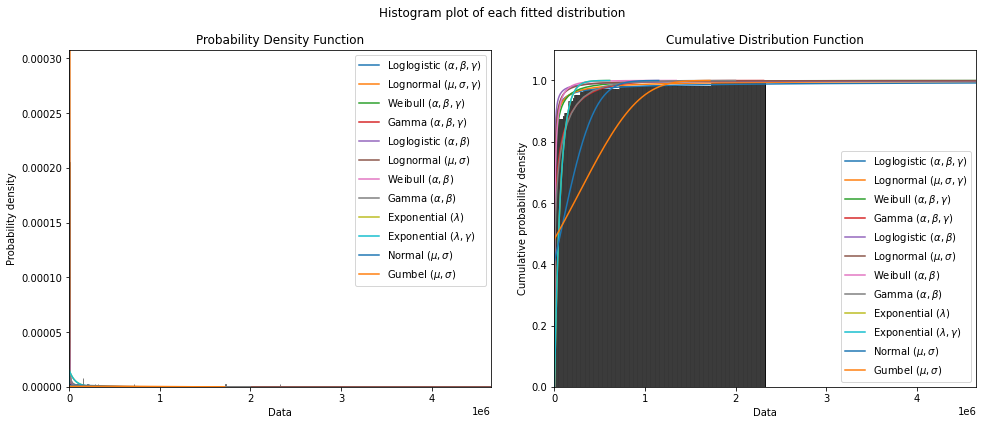

The best fitting distribution was Loglogistic_3P which had parameters [6.72523964e+02 5.46970278e-01 1.99999900e+02]
Subsystem: I-O


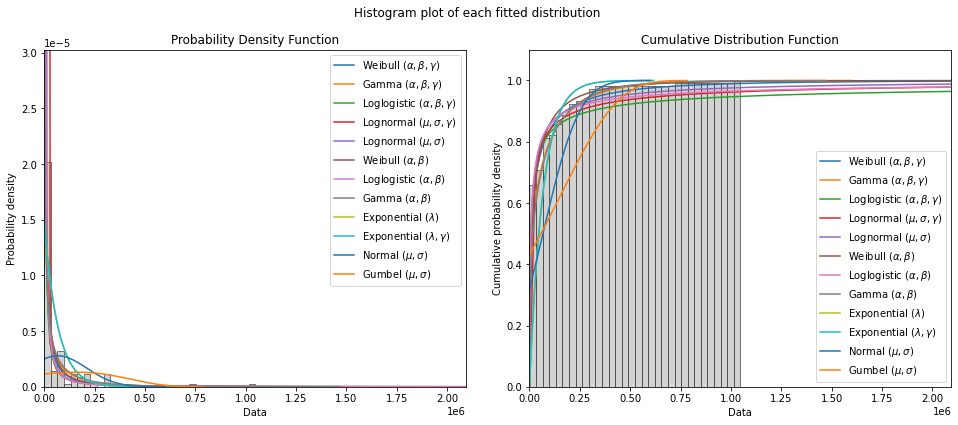

The best fitting distribution was Weibull_3P which had parameters [2.20669245e+04 3.97370861e-01 1.07999900e+02]
Subsystem: NET


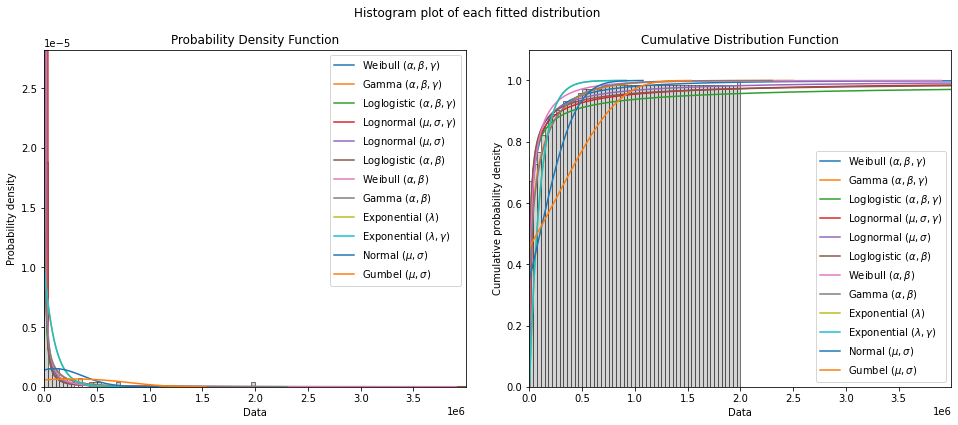

The best fitting distribution was Weibull_3P which had parameters [2.84207649e+04 3.86732768e-01 1.04999900e+02]
Subsystem: PRO


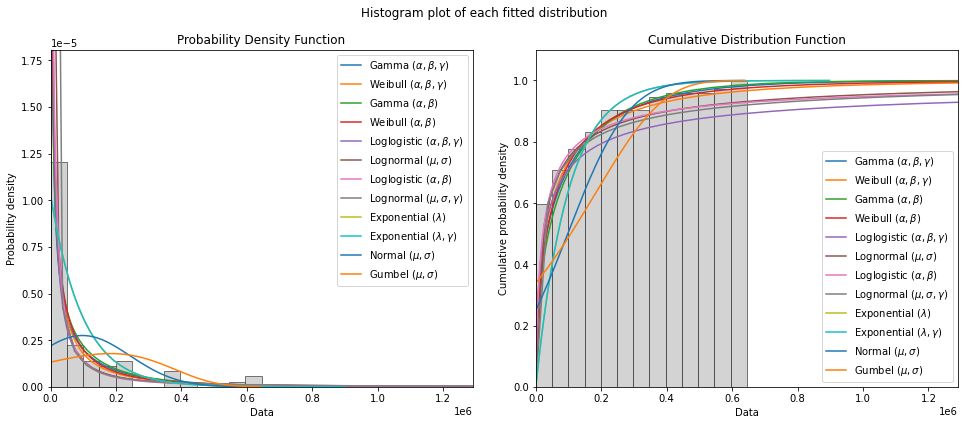

The best fitting distribution was Gamma_3P which had parameters [2.62583554e+05 3.70884964e-01 1.05999900e+02]


In [66]:
for subsys in subsystems.index:
    print('Subsystem:', subsys)
    data = dict_df_cat_stat[subsys]['Interarrival'].dropna().to_numpy()
    
    try:
        results = Fit_Everything(failures=data, show_PP_plot = False, show_probability_plot = False, print_results = False, show_histogram_plot = True) 
        print('The best fitting distribution was', results.best_distribution_name, 'which had parameters', results.best_distribution.parameters)
    except Exception as e:
        print('Exception:', e)

### Empirical reliability

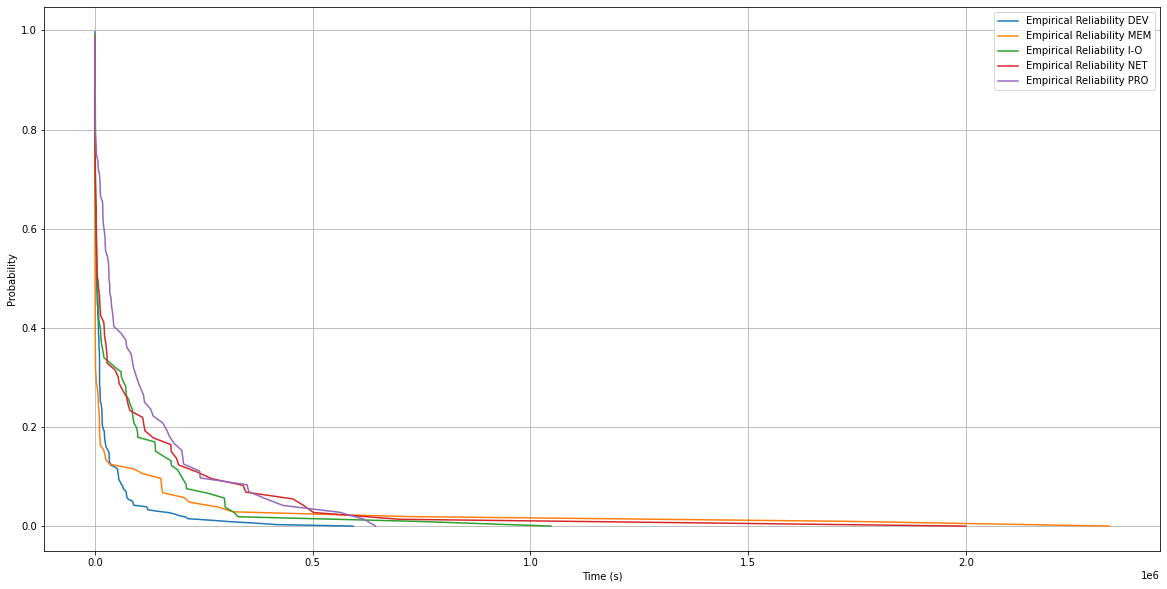

In [67]:
plt.figure(figsize=(20,10))
    
for subsys in subsystems.index:
    
    ecdf = ECDF(dict_df_cat_stat[subsys]['Interarrival'].dropna())

    plt.plot(ecdf.x, 1-ecdf.y, label = 'Empirical Reliability ' + str(subsys))
    plt.xlabel('Time (s)')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid()

## Types

### Empirical time to failure distribution

Type: computation


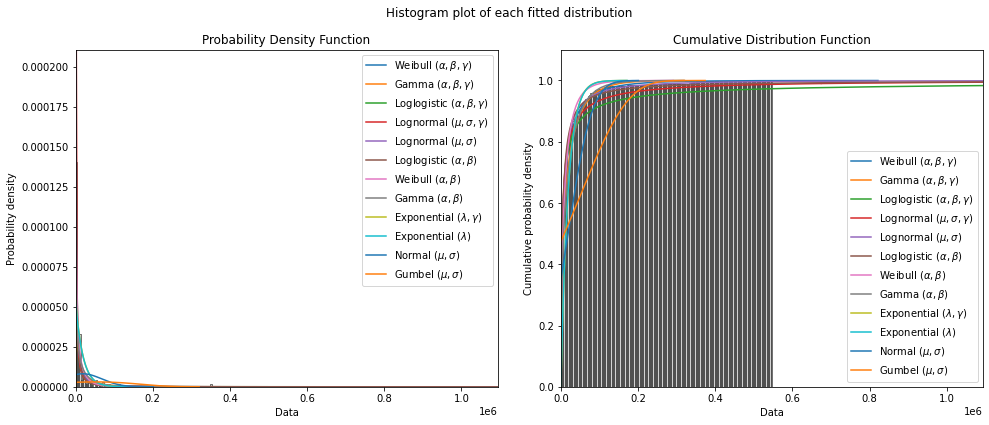

The best fitting distribution was Weibull_3P which had parameters [8.47335884e+03 4.85382713e-01 1.99999900e+02]
Type: master


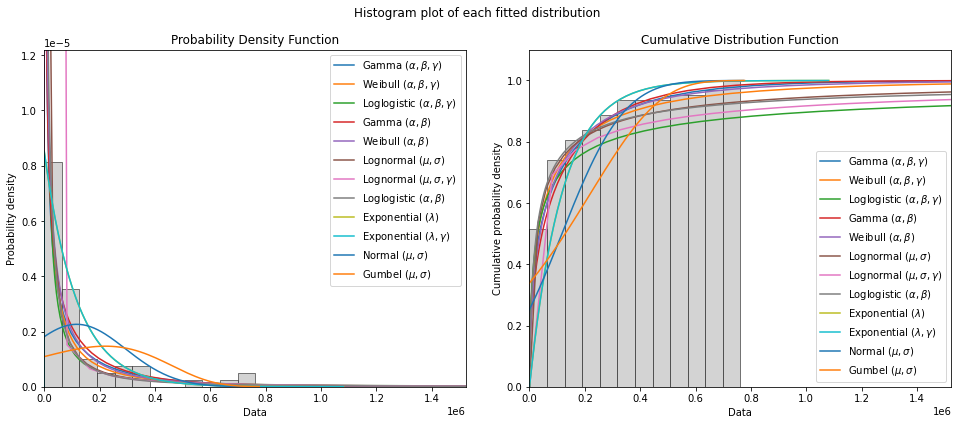

The best fitting distribution was Gamma_3P which had parameters [3.39904866e+05 3.45022346e-01 1.84999900e+02]
Type: storage


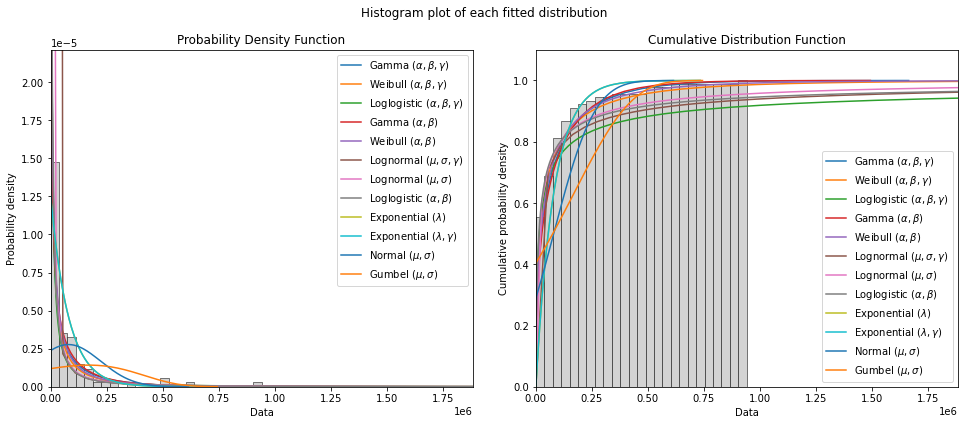

The best fitting distribution was Gamma_3P which had parameters [2.43786307e+05 3.26897268e-01 1.07999900e+02]
Type: login


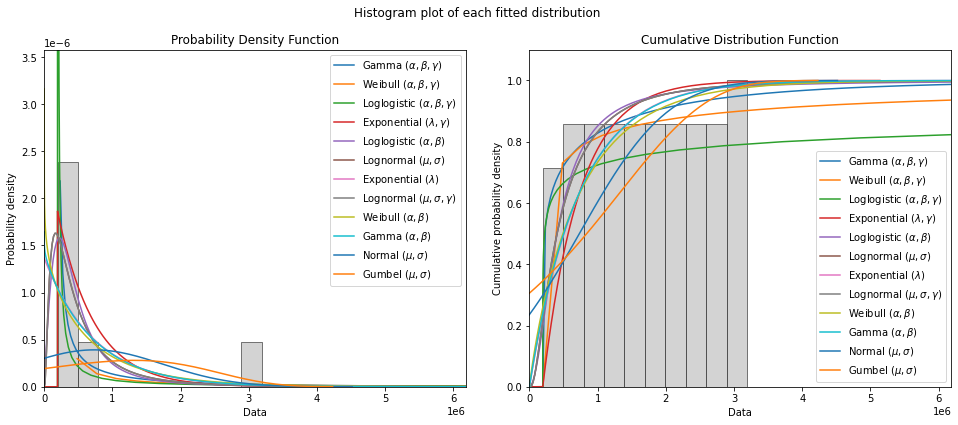

The best fitting distribution was Gamma_3P which had parameters [3.29605601e+06 1.62881377e-01 1.95077000e+05]


In [68]:
for t in types.index:
    print('Type:', t)
    data = dict_df_type_stat[t]['Interarrival'].dropna().to_numpy()
    
    try:
        results = Fit_Everything(failures=data, show_PP_plot = False, show_probability_plot = False, print_results = False, show_histogram_plot = True) 
        print('The best fitting distribution was', results.best_distribution_name, 'which had parameters', results.best_distribution.parameters)
    except Exception as e:
        print('Exception:', e)

### Empirical reliability

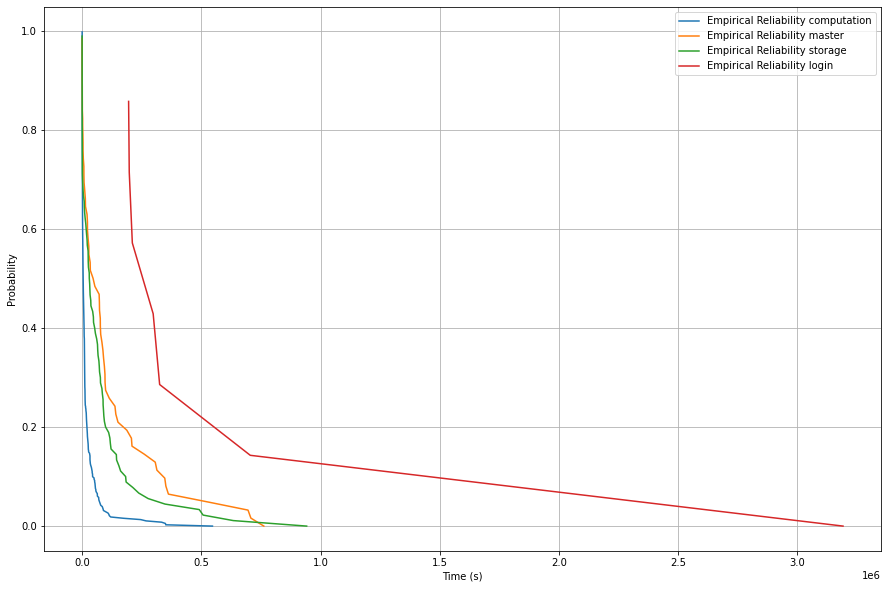

In [69]:
plt.figure(figsize=(15,10))
    
for t in types.index:
    ecdf = ECDF(dict_df_type_stat[t]['Interarrival'].dropna())

    plt.plot(ecdf.x, 1-ecdf.y, label = 'Empirical Reliability ' + str(t))

plt.xlabel('Time (s)')
plt.ylabel('Probability')
plt.legend()
plt.grid()

## Top Nodes

### Empirical time to failure distribution

Node: tg-c401


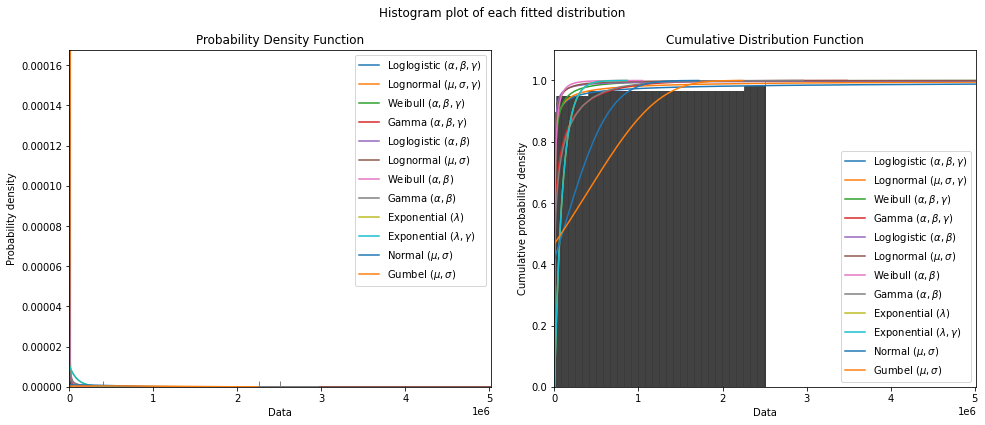

The best fitting distribution was Loglogistic_3P which had parameters [8.07878977e+02 5.06861718e-01 2.03999900e+02]
Node: tg-master


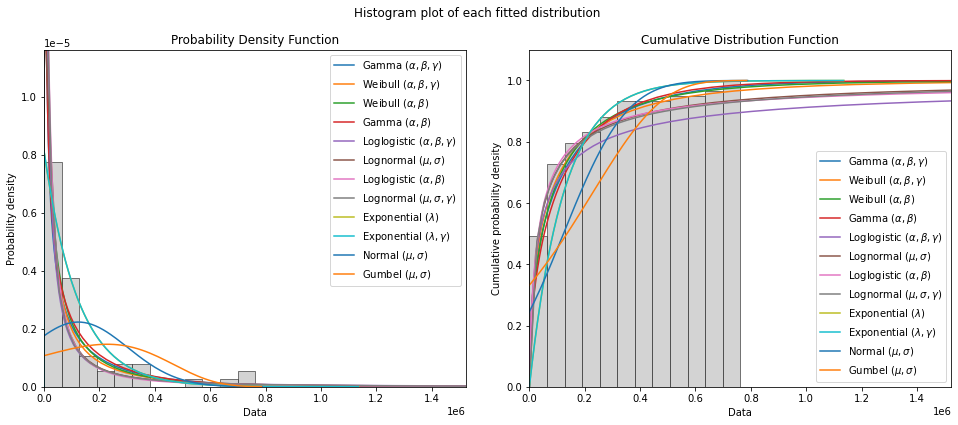

The best fitting distribution was Gamma_3P which had parameters [3.05994004e+05 4.02660321e-01 2.10999900e+02]


In [70]:
top_2 = [k for k in dict_node_num_tup if dict_node_num_tup[k] > 30]

for node in top_2:
    print('Node:', node)
    data = dict_df_node_stat[node]['Interarrival'].dropna().to_numpy()
    
    results = Fit_Everything(failures=data, show_PP_plot = False, show_probability_plot = False, print_results = False, show_histogram_plot = True) 
    print('The best fitting distribution was', results.best_distribution_name, 'which had parameters', results.best_distribution.parameters)

### Empirical reliability

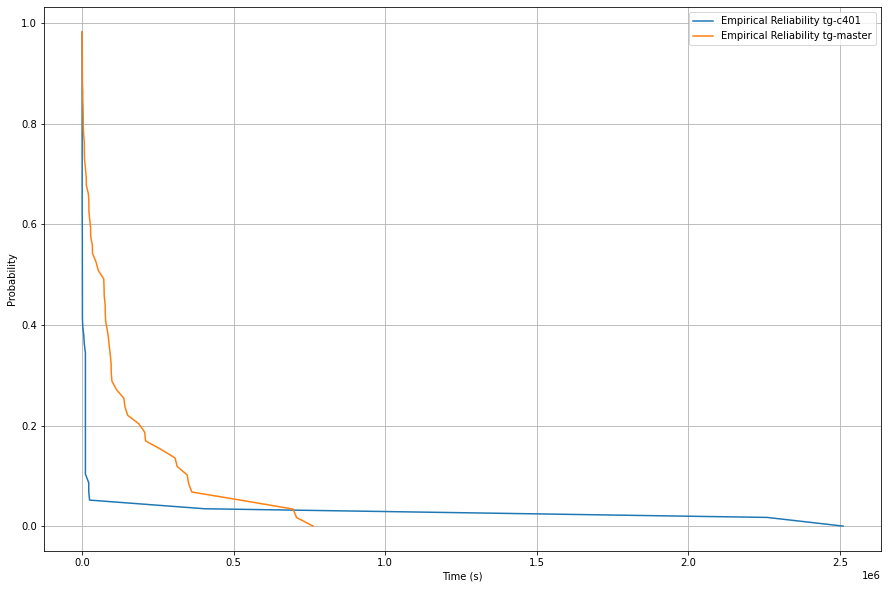

In [71]:
plt.figure(figsize=(15,10))
    
for node in top_2:
    ecdf = ECDF(dict_df_node_stat[node]['Interarrival'].dropna())

    plt.plot(ecdf.x, 1-ecdf.y, label = 'Empirical Reliability ' + str(node))

plt.xlabel('Time (s)')
plt.ylabel('Probability')
plt.legend()
plt.grid()

## Bottleneck

### Empirical time to failure distribution

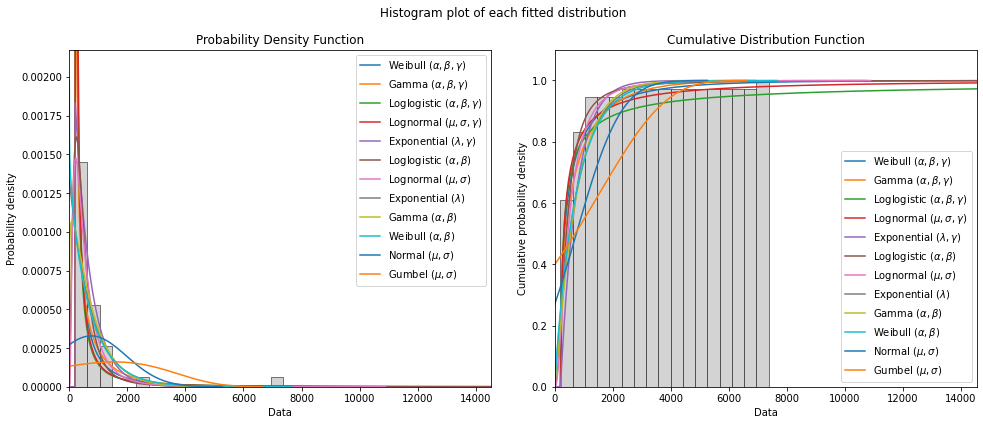

The best fitting distribution was Weibull_3P which had parameters [278.67054042   0.50538949 203.9999    ]


In [72]:
data = df_bottleneck_stat['Interarrival'].dropna().to_numpy()
   
results = Fit_Everything(failures=data, show_PP_plot = False, show_probability_plot = False, print_results = False, show_histogram_plot = True) 
print('The best fitting distribution was', results.best_distribution_name, 'which had parameters', results.best_distribution.parameters)

### Empirical reliability

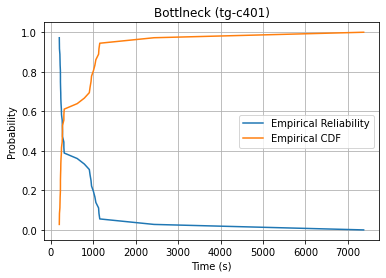

In [73]:
ecdf = ECDF(df_bottleneck_stat['Interarrival'].dropna())

plt.plot(ecdf.x, 1-ecdf.y, label = 'Empirical Reliability')
plt.plot(ecdf.x, ecdf.y, label = 'Empirical CDF')
plt.title('Bottlneck (tg-c401)')
plt.xlabel('Time (s)')
plt.ylabel('Probability')
plt.legend()
plt.grid()

### General Analysis

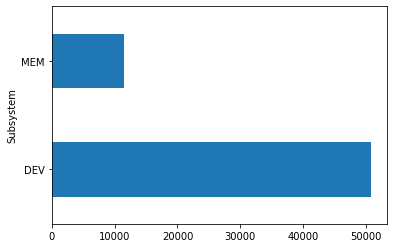

In [74]:
df_bottleneck.groupby(by='Subsystem').Timestamp.count().plot.barh()
plt.show()

In [75]:
df_bottleneck.groupby(by=['Subsystem','Message']).count().drop(columns=['Node', 'Type', 'Tuple'])

Timestamp
Subsystem Message                                              
DEV       + Platform Specific Error Detail:                5474
          +BEGIN HARDWARE ERROR STATE AT CPE               6030
          +END HARDWARE ERROR STATE AT CPE                 3830
          +Platform PCI Component Error Info Section       6805
          +Platform Specific Error Info Section            5416
          Component Info: Vendor Id =x x                  23152
MEM       + Mem Error Detail:                                 4
          Physical Address x                              11552

In [76]:
# risolvere truncation e collision
# clustering